In this code ,I use three method to solve 2-d poisson equations with suitable Dirichlet boundary condition.

Method 1 : Construct matrix 

Method 2 : Use DST

Method 3 : Use FFT 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft,idst,dst

In [2]:
def Thomas_algorithm(A,F,m):
    
    c=A.diagonal(1)
    b=A.diagonal()
    a=A.diagonal(-1)
    c_prime=np.zeros(len(c))
    d_prime=np.zeros(len(b))
    u=np.zeros(m-1)
    
    c_prime[0]=c[0]/b[0]
    for i in range(1,m-2):
        c_prime[i]=c[i]/(b[i]-a[i]*c_prime[i-1])
    
    d_prime[0]=F[0]/b[0]
    
    for i in range(1,m-1):
        d_prime[i]=(F[i]-a[i-1]*d_prime[i-1])/(b[i]-a[i-1]*c_prime[i-1])
    
    u[-1]=d_prime[-1]
    for i in range(1,m-1):
        u[m-2-i]=d_prime[m-2-i]-c_prime[m-2-i]*u[m-2-i+1]
    
    return u

In [3]:
def force1(points):
    return 4*np.ones(len(points)).reshape(len(points),1)
def force2(points):
    return 2*np.exp(np.sum(points,1)).reshape(len(points),1)

def exact_sol1(points):
    return np.sum(points**2,1).reshape(len(points),1)

def exact_sol2(points):
    return np.exp(np.sum(points,1)).reshape(len(points),1)

In [4]:
def total_b1(a,b,n):
    x=np.linspace(a,b,n+1)
    x=x[1:-1]
    y=np.linspace(a,b,n+1)
    y=y[1:-1]
    h=1/n
    [X,Y]=np.meshgrid(x,y)
    grid_points=np.hstack([X.reshape(len(X)**2,1),Y.reshape(len(Y)**2,1)])
    F=force1(grid_points)
    step=n-1
    
    Ui0=(grid_points[1:n-2][:,0])**2+a**2
    Ui0=Ui0.reshape(len(Ui0),1)
    F[1:n-2]=F[1:n-2]-((1/h)**2)*Ui0

    Uin=grid_points[1+(n-2)*step:n-2+(n-2)*step][:,0]**2+b**2
    Uin=Uin.reshape(len(Uin),1)
    F[1+(n-2)*step:n-2+(n-2)*step]=F[1+(n-2)*step:n-2+(n-2)*step]-((1/h)**2)*Uin
    
    for k in range(n-3):    
        F[n-1+k*step]=F[n-1+k*step]-((1/h)**2)*((grid_points[n-1+k*step][1])**2+a**2)

    for k in range(n-3):
        F[n-2+n-1+k*step]=F[n-2+n-1+k*step]-((1/h)**2)*((grid_points[n-2+n-1+k*step][1])**2+b**2)
        
    F[0]=F[0]-((1/h)**2)*((grid_points[0][1])**2+a**2+(grid_points[0][0])**2+a**2)
    F[0+n-2]=F[0+n-2]-((1/h)**2)*((grid_points[0+n-2][1])**2+b**2+(grid_points[0+n-2][0])**2+a**2)
    F[0+(n-2)*(n-1)]=F[0+(n-2)*(n-1)]-((1/h)**2)*(grid_points[0+(n-2)*(n-1)][1]**2+a**2+grid_points[0+(n-2)*(n-1)][0]**2+b**2)
    F[n-2+(n-2)*(n-1)]=F[n-2+(n-2)*(n-1)]-((1/h)**2)*(grid_points[n-2+(n-2)*(n-1)][0]**2+b**2+grid_points[n-2+(n-2)*(n-1)][1]**2+b**2)
    
    return F

In [5]:
def total_b2(a,b,n):
    x=np.linspace(a,b,n+1)
    x=x[1:-1]
    y=np.linspace(a,b,n+1)
    y=y[1:-1]
    h=1/n
    [X,Y]=np.meshgrid(x,y)
    grid_points=np.hstack([X.reshape(len(X)**2,1),Y.reshape(len(Y)**2,1)])
    F=force2(grid_points)
    step=n-1
    
    Ui0=np.exp((grid_points[1:n-2][:,0])+a)
    Ui0=Ui0.reshape(len(Ui0),1)
    F[1:n-2]=F[1:n-2]-((1/h)**2)*Ui0

    Uin=np.exp(grid_points[1+(n-2)*step:n-2+(n-2)*step][:,0]+b)
    Uin=Uin.reshape(len(Uin),1)
    F[1+(n-2)*step:n-2+(n-2)*step]=F[1+(n-2)*step:n-2+(n-2)*step]-((1/h)**2)*Uin
    
    for k in range(n-3):    
        F[n-1+k*step]=F[n-1+k*step]-((1/h)**2)*np.exp((grid_points[n-1+k*step][1])+a)

    for k in range(n-3):
        F[n-2+n-1+k*step]=F[n-2+n-1+k*step]-((1/h)**2)*np.exp((grid_points[n-2+n-1+k*step][1])+b)
        
    F[0]=F[0]-((1/h)**2)*(np.exp((grid_points[0][1])+a)+np.exp((grid_points[0][0])+a))
    F[0+n-2]=F[0+n-2]-((1/h)**2)*(np.exp((grid_points[0+n-2][1])+b)+np.exp((grid_points[0+n-2][0])+a))
    F[0+(n-2)*(n-1)]=F[0+(n-2)*(n-1)]-((1/h)**2)*(np.exp(grid_points[0+(n-2)*(n-1)][1]+a)+np.exp(grid_points[0+(n-2)*(n-1)][0]+b))
    F[n-2+(n-2)*(n-1)]=F[n-2+(n-2)*(n-1)]-((1/h)**2)*(np.exp(grid_points[n-2+(n-2)*(n-1)][0]+b)+np.exp(grid_points[n-2+(n-2)*(n-1)][1]+b))
    
    return F

## Solve Poisson equation using 5-point Laplation

Method 1 : Construct the large matrix A and to solve it

(a) exact solution $u(x,y)=x^2+y^2$

In [6]:
#we want to solve AU=b
#Discretization
n=10
x=np.linspace(0,1,n+1)
x=x[1:-1]
y=np.linspace(0,1,n+1)
y=y[1:-1]
h=1/n
[X,Y]=np.meshgrid(x,y)
X.reshape(len(X)**2,1)
Y.reshape(len(Y)**2,1)
grid_points=np.hstack([X.reshape(len(X)**2,1),Y.reshape(len(Y)**2,1)])

#Given b
F=total_b1(0,1,n)
b=(h**2)*F
#F=total_b2(0,1,n)

#construct A
I=np.eye(n-1)
T=(np.eye(n-1,k=1)-4*np.eye(n-1)+np.eye(n-1,k=-1))#*(1/h)**2
I2=(np.eye(n-1,k=1)+np.eye(n-1,k=-1))

A=np.kron(I2,I)+np.kron(I,T)

U=np.linalg.solve(A,b)


In [7]:
np.linalg.norm(exact_sol1(grid_points)-U)

3.15965297802364e-15

(b) exact solution $u(x,y)=e^{(x+y)}$

In [8]:
#we want to solve AU=b
#Discretization
n=40
x=np.linspace(0,1,n+1)
x=x[1:-1]
y=np.linspace(0,1,n+1)
y=y[1:-1]
h=1/n
[X,Y]=np.meshgrid(x,y)
X.reshape(len(X)**2,1)
Y.reshape(len(Y)**2,1)
grid_points=np.hstack([X.reshape(len(X)**2,1),Y.reshape(len(Y)**2,1)])

#Given b
F=total_b2(0,1,n)
b=(h**2)*F
#F=total_b2(0,1,n)

#construct A
I=np.eye(n-1)
T=(np.eye(n-1,k=1)-4*np.eye(n-1)+np.eye(n-1,k=-1))#*(1/h)**2
I2=(np.eye(n-1,k=1)+np.eye(n-1,k=-1))

A=np.kron(I2,I)+np.kron(I,T)

U=np.linalg.solve(A,b)

In [9]:
np.linalg.norm(exact_sol2(grid_points)-U)

0.0004951169613611275

Method 2 use DST

(1) orthogonal matrix

(2) DST

(1) orthogonal matrix

In [23]:
#consruct othogonal matrix
Q=[]
j=np.arange(1,n,1)
for i in range(1,n):
    Q.append(np.sin(i*np.pi*h*j))
Q=np.array(Q)
Q=Q*np.sqrt(2/n)

In [24]:
def solve_one_system_Q(n,Q,F):
    h=1/n
    Ui=[]
    for i in range(n-1):
        bi=[]
        ui=[]
        step=n-1
        for k in range(n-1):
            bi.append(np.matmul(Q,(h**2)*F[0+k*step:n-1+k*step])[i].tolist())
        bi=np.array(bi).reshape(len(bi),1)
        A=np.eye(n-1,k=1)+np.eye(n-1,k=-1)+2*(np.cos(h*(i+1)*np.pi)-2)*np.eye(n-1)
        ui=Thomas_algorithm(A,bi,n)
        Ui.append(ui)
    return Ui

In [25]:
def transform_Q(Ui):
    U_num=[]
    for j in range(n-1):
        U=[]
        for k in range(n-1):
            U.append(Ui[k][j])
        U_num.append(np.matmul(Q,U))
    return U_num

(a) exact solution $u(x,y)=x^2+y^2$

In [26]:
#Discretization
n=10
x=np.linspace(0,1,n+1)
x=x[1:-1]
y=np.linspace(0,1,n+1)
y=y[1:-1]
h=1/n
[X,Y]=np.meshgrid(x,y)
X.reshape(len(X)**2,1)
Y.reshape(len(Y)**2,1)
grid_points=np.hstack([X.reshape(len(X)**2,1),Y.reshape(len(Y)**2,1)])

F=total_b1(0,1,n)

In [27]:
Ui=solve_one_system_Q(n,Q,F)

In [28]:
U_num=transform_Q(Ui)

In [29]:
np.linalg.norm(exact_sol1(grid_points)-np.stack(U_num).reshape(n-1*n-1,1))

4.7709336274776596e-15

(b) exact solution $u(x,y)=e^{(x+y)}$

In [30]:
#Discretization
n=10
x=np.linspace(0,1,n+1)
x=x[1:-1]
y=np.linspace(0,1,n+1)
y=y[1:-1]
h=1/n
[X,Y]=np.meshgrid(x,y)
X.reshape(len(X)**2,1)
Y.reshape(len(Y)**2,1)
grid_points=np.hstack([X.reshape(len(X)**2,1),Y.reshape(len(Y)**2,1)])

F=total_b2(0,1,n)

In [31]:
Ui=solve_one_system_Q(n,Q,F)
U_num=transform_Q(Ui)

In [32]:
np.linalg.norm(exact_sol2(grid_points)-np.stack(U_num).reshape(n-1*n-1,1))

0.0019620005219436877

(2) DST

In [33]:
def solve_one_system(n,F):
    h=1/n
    Ui=[]
    for i in range(n-1):
        bi=[]
        ui=[]
        step=n-1
        for k in range(n-1):
            bi.append((0.5*dst((h**2)*F[0+k*step:n-1+k*step].flatten(),type=1)*np.sqrt(2/n))[i].tolist())
        bi=np.array(bi).reshape(len(bi),1)
        A=np.eye(n-1,k=1)+np.eye(n-1,k=-1)+2*(np.cos(h*(i+1)*np.pi)-2)*np.eye(n-1)
        ui=Thomas_algorithm(A,bi,n)
        Ui.append(ui)
    return Ui

In [34]:
def transform(Ui):
    U_num=[]
    for j in range(n-1):
        U=[]
        for k in range(n-1):
            U.append(Ui[k][j])
        U_num.append(2*idst(np.array(U).flatten(),type=1)/np.sqrt(2/n))
    return U_num

(a) exact solution $u(x,y)=x^2+y^2$

In [35]:
#Discretization
n=10
x=np.linspace(0,1,n+1)
x=x[1:-1]
y=np.linspace(0,1,n+1)
y=y[1:-1]
h=1/n
[X,Y]=np.meshgrid(x,y)
X.reshape(len(X)**2,1)
Y.reshape(len(Y)**2,1)
grid_points=np.hstack([X.reshape(len(X)**2,1),Y.reshape(len(Y)**2,1)])

F=total_b1(0,1,n)

In [36]:
Ui=solve_one_system(n,F)

In [37]:
U_num=transform(Ui)

In [38]:
np.linalg.norm(exact_sol1(grid_points)-np.stack(U_num).reshape(n-1*n-1,1))

3.315769528984564e-15

(b) exact solution $u(x,y)=e^{(x+y)}$

In [39]:
#Discretization
n=10
x=np.linspace(0,1,n+1)
x=x[1:-1]
y=np.linspace(0,1,n+1)
y=y[1:-1]
h=1/n
[X,Y]=np.meshgrid(x,y)
X.reshape(len(X)**2,1)
Y.reshape(len(Y)**2,1)
grid_points=np.hstack([X.reshape(len(X)**2,1),Y.reshape(len(Y)**2,1)])

F=total_b2(0,1,n)

In [40]:
Ui=solve_one_system(n,F)
U_num=transform(Ui)

In [41]:
np.linalg.norm(exact_sol2(grid_points)-np.stack(U_num).reshape(n-1*n-1,1))

0.0019620005219413293

Method 3: FFT

In [42]:
def solve_one_system_FFT(n,F):
    h=1/n
    Ui=[]
    for i in range(n-1):
        bi=[]
        ui=[]
        step=n-1
        for k in range(n-1):
            F_exttend=np.zeros(2*n)
            F_exttend[1:n]=(h**2)*F[0+k*step:n-1+k*step].flatten()

            bi.append(np.imag((2*ifft(F_exttend)*n*np.sqrt(2/n))[1:n])[i].tolist())
        bi=np.array(bi).reshape(len(bi),1)
        A=np.eye(n-1,k=1)+np.eye(n-1,k=-1)+2*(np.cos(h*(i+1)*np.pi)-2)*np.eye(n-1)
        ui=Thomas_algorithm(A,bi,n)
        Ui.append(ui)
    return Ui

In [43]:
def transform_FFT(Ui):
    U_num=[]
    for j in range(n-1):
        U=[]
        for k in range(n-1):
            U.append(Ui[k][j])
        U_extend=np.zeros(2*n)
        U_extend[1:n]=U
        U_num.append(-1*np.imag(fft((U_extend)*np.sqrt(2/n)))[1:n])
    return U_num

(a) exact solution $u(x,y)=x^2+y^2$

In [193]:
#Discretization
n=64
x=np.linspace(0,1,n+1)
x=x[1:-1]
y=np.linspace(0,1,n+1)
y=y[1:-1]
h=1/n
[X,Y]=np.meshgrid(x,y)
X.reshape(len(X)**2,1)
Y.reshape(len(Y)**2,1)
grid_points=np.hstack([X.reshape(len(X)**2,1),Y.reshape(len(Y)**2,1)])

F=total_b1(0,1,n)

In [194]:
Ui=solve_one_system_FFT(n,F)

In [195]:
U_num=transform_FFT(Ui)

In [196]:
np.linalg.norm(exact_sol1(grid_points)-np.stack(U_num).reshape(n-1*n-1,1))

2.707160766531936e-13

In [182]:
#Err8=np.linalg.norm(exact_sol1(grid_points)-np.stack(U_num).reshape(n-1*n-1,1))

In [187]:
#Err16=np.linalg.norm(exact_sol1(grid_points)-np.stack(U_num).reshape(n-1*n-1,1))

In [192]:
#Err32=np.linalg.norm(exact_sol1(grid_points)-np.stack(U_num).reshape(n-1*n-1,1))

In [197]:
#Err64=np.linalg.norm(exact_sol1(grid_points)-np.stack(U_num).reshape(n-1*n-1,1))

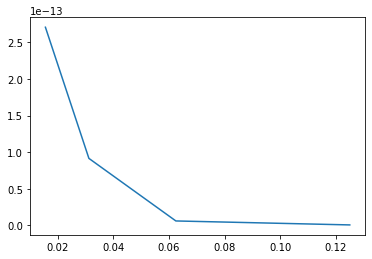

In [198]:
Err=[Err8,Err16,Err32,Err64]
t=np.arange(3,7)
plt.plot(1/2**t,Err)


In [199]:
Err

[7.125132513437735e-16,
 6.126127754814409e-15,
 9.158372662324876e-14,
 2.707160766531936e-13]

In [202]:
i=2
np.log2(Err[i]/Err[i+1])

-1.5636173896335672

(b) exact solution $u(x,y)=e^{(x+y)}$

In [213]:
#Discretization
n=32
x=np.linspace(0,1,n+1)
x=x[1:-1]
y=np.linspace(0,1,n+1)
y=y[1:-1]
h=1/n
[X,Y]=np.meshgrid(x,y)
X.reshape(len(X)**2,1)
Y.reshape(len(Y)**2,1)
grid_points=np.hstack([X.reshape(len(X)**2,1),Y.reshape(len(Y)**2,1)])

F=total_b2(0,1,n)

In [214]:
Ui=solve_one_system_FFT(n,F)

In [215]:
U_num=transform_FFT(Ui)

In [216]:
np.linalg.norm(exact_sol2(grid_points)-np.stack(U_num).reshape(n-1*n-1,1))

0.0006186827991592411

In [207]:
#Err8=np.linalg.norm(exact_sol1(grid_points)-np.stack(U_num).reshape(n-1*n-1,1))

In [212]:
#Err16=np.linalg.norm(exact_sol1(grid_points)-np.stack(U_num).reshape(n-1*n-1,1))

In [217]:
#Err32=np.linalg.norm(exact_sol1(grid_points)-np.stack(U_num).reshape(n-1*n-1,1))

## Use 9-point Laplacian

In [53]:
def modified_F1(F,n):
    F=F.reshape(n+1,n+1)
    F_bar=[]
    for x_axis in range(1,n):
        for y_axis in range(1,n):
            F_bar.append(F[x_axis+1][y_axis]+F[x_axis-1][y_axis]+F[x_axis][y_axis+1]+F[x_axis][y_axis-1]-4*F[x_axis][y_axis])
    return (1/12)*np.array(F_bar)

In [54]:
def modified_F2(F,n,a,b):
    step=n-1
    h=1/n
    Ui0=(4*(grid_points[1:n-2][:,0])**2+a**2)+(grid_points[2:n-1][:,0])**2+a**2+(grid_points[0:n-3][:,0])**2+a**2
    F[1:n-2]=F[1:n-2]-(1/(6*h**2))*Ui0
    
    Uin=4*(grid_points[1+(n-2)*step:n-2+(n-2)*step][:,0]**2+b**2)+grid_points[2+(n-2)*step:n-1+(n-2)*step][:,0]**2+b**2+grid_points[(n-2)*step:n-3+(n-2)*step][:,0]**2+b**2
    F[1+(n-2)*step:n-2+(n-2)*step]=F[1+(n-2)*step:n-2+(n-2)*step]-(1/(6*h**2))*Uin
    
    for k in range(n-3):
        F[n-1+k*step]=F[n-1+k*step]-(1/(6*h**2))*((4*(grid_points[n-1+k*step][1]**2+a**2))+(grid_points[n-1+(k+1)*step][1]**2+a**2)+(grid_points[n-1+(k-1)*step][1]**2+a**2))
    
    for k in range(n-3):
        F[n-2+n-1+k*step]=F[n-2+n-1+k*step]-(1/(6*h**2))*(4*(grid_points[n-2+n-1+k*step][1]**2+b**2)+(grid_points[n-2+n-1+(k+1)*step][1]**2+b**2)+(grid_points[n-2+n-1+(k-1)*step][1]**2+b**2))
    
    F[0]=F[0]-(1/(6*h**2))*(4*((grid_points[0][1]**2+a**2)+grid_points[0][0]**2+a**2)+(grid_points[1][0])**2+a**2+(grid_points[1][0])**2+a**2+(a**2+a**2))
    F[0+n-2]=F[0+n-2]-(1/(6*h**2))*(4*((grid_points[0+n-2][1]**2+b**2)+(grid_points[0+n-2][0]**2+a**2))+(grid_points[0+n-2+step][1]**2+b**2)+(grid_points[0+n-3][0]**2+a**2)+(a**2+b**2))
    F[0+(n-2)*(n-1)]=F[0+(n-2)*(n-1)]-(1/(6*h**2))*(4*((grid_points[0+(n-2)*(n-1)][1]**2+a**2)+(grid_points[0+(n-2)*(n-1)][0]**2+b**2))+(grid_points[1+(n-2)*(n-1)][0]**2+b**2)+(a**2+b**2)+(grid_points[0+(n-3)*(n-1)][1]**2+a**2))
    F[n-2+(n-2)*(n-1)]=F[n-2+(n-2)*(n-1)]-(1/(6*h**2))*(4*((grid_points[n-2+(n-2)*(n-1)][1]**2+b**2)+(grid_points[n-2+(n-2)*(n-1)][0]**2+b**2))+(b**2+b**2)+(grid_points[n-3+(n-2)*(n-1)][0]**2+b**2)+(grid_points[n-2+(n-3)*(n-1)][1]**2+b**2))
    
    return F 

In [55]:
def modified_F3(F,n,a,b):
    step=n-1
    h=1/n
    Ui0=4*np.exp(grid_points[1:n-2][:,0]+a)+np.exp(grid_points[2:n-1][:,0]+a)+np.exp(grid_points[0:n-3][:,0]+a)
    F[1:n-2]=F[1:n-2]-(1/(6*h**2))*Ui0
    
    Uin=4*np.exp(grid_points[1+(n-2)*step:n-2+(n-2)*step][:,0]+b)+np.exp(grid_points[2+(n-2)*step:n-1+(n-2)*step][:,0]+b)+np.exp(grid_points[(n-2)*step:n-3+(n-2)*step][:,0]+b)
    F[1+(n-2)*step:n-2+(n-2)*step]=F[1+(n-2)*step:n-2+(n-2)*step]-(1/(6*h**2))*Uin
    
    for k in range(n-3):
        F[n-1+k*step]=F[n-1+k*step]-(1/(6*h**2))*(4*np.exp(grid_points[n-1+k*step][1]+a)+np.exp(grid_points[n-1+(k+1)*step][1]+a)+np.exp(grid_points[n-1+(k-1)*step][1]+a))
    
    for k in range(n-3):
        F[n-2+n-1+k*step]=F[n-2+n-1+k*step]-(1/(6*h**2))*(4*np.exp(grid_points[n-2+n-1+k*step][1]+b)+np.exp(grid_points[n-2+n-1+(k+1)*step][1]+b)+np.exp(grid_points[n-2+n-1+(k-1)*step][1]+b))
    
    F[0]=F[0]-(1/(6*h**2))*(4*(np.exp(grid_points[0][1]+a)+np.exp(grid_points[0][0]+a))+np.exp(grid_points[1][0]+a)+np.exp(grid_points[1][0]+a)+np.exp(a+a))
    F[0+n-2]=F[0+n-2]-(1/(6*h**2))*(4*(np.exp(grid_points[0+n-2][1]+b)+np.exp(grid_points[0+n-2][0]+a))+np.exp(grid_points[0+n-2+step][1]+b)+np.exp(grid_points[0+n-3][0]+a)+np.exp(a+b))
    F[0+(n-2)*(n-1)]=F[0+(n-2)*(n-1)]-(1/(6*h**2))*(4*(np.exp(grid_points[0+(n-2)*(n-1)][1]+a)+np.exp(grid_points[0+(n-2)*(n-1)][0]+b))+np.exp(grid_points[1+(n-2)*(n-1)][0]+b)+np.exp(a+b)+np.exp(grid_points[0+(n-3)*(n-1)][1]+a))
    F[n-2+(n-2)*(n-1)]=F[n-2+(n-2)*(n-1)]-(1/(6*h**2))*(4*(np.exp(grid_points[n-2+(n-2)*(n-1)][1]+b)+np.exp(grid_points[n-2+(n-2)*(n-1)][0]+b))+np.exp(b+b)+np.exp(grid_points[n-3+(n-2)*(n-1)][0]+b)+np.exp(grid_points[n-2+(n-3)*(n-1)][1]+b))
    
    return F 

## Construct matrix

In [88]:
n=10
[a,b]=[0,1]
x=np.linspace(a,b,n+1)

y=np.linspace(a,b,n+1)
h=1/n
[X,Y]=np.meshgrid(x,y)
grid_points=np.hstack([X.reshape(len(X)**2,1),Y.reshape(len(Y)**2,1)])
F=force1(grid_points)
F_bar=modified_F1(F,n)

x=np.linspace(a,b,n+1)
x=x[1:-1]
y=np.linspace(a,b,n+1)
y=y[1:-1]
h=1/n
[X,Y]=np.meshgrid(x,y)
grid_points=np.hstack([X.reshape(len(X)**2,1),Y.reshape(len(Y)**2,1)])
F=F_bar+force1(grid_points).flatten()

In [89]:
F=modified_F2(F,n,a,b)#modified_F3(F,n,a,b) for case (b)

In [90]:
#construct A
I=np.eye(n-1)
T=(4*np.eye(n-1,k=1)-20*np.eye(n-1)+4*np.eye(n-1,k=-1))#*(1/h)**2
I2=(np.eye(n-1,k=1)+np.eye(n-1,k=-1))
B=(np.eye(n-1,k=1)+4*np.eye(n-1)+np.eye(n-1,k=-1))#*(1/h)**2
A=np.kron(I2,B)+np.kron(I,T)

In [91]:
F=F.reshape(len(F),1)
bs=6*(h**2)*F
U=np.linalg.solve(A,bs)

In [92]:
np.linalg.norm(exact_sol1(grid_points)-U,np.inf)

1.5543122344752192e-15

In [94]:
np.linalg.norm(exact_sol1(grid_points)-U,np.inf)

1.5543122344752192e-15

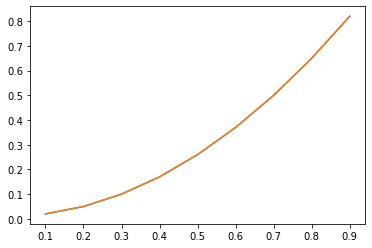

In [95]:
plt.plot(x,U[:n-1])
plt.plot(x,exact_sol1(grid_points)[:n-1])

## FFT

In [118]:
def one_system_FFT_9(F,n,ET,EB):
    h=1/n
    Ui=[]
    for i in range(n-1):
        bi=[]
        ui=[]
        step=n-1
        for k in range(n-1):
            F_exttend=np.zeros(2*n)
            F_exttend[1:n]=6*(h**2)*F[0+k*step:n-1+k*step].flatten()
            bi.append(np.imag((2*ifft(F_exttend)*n*np.sqrt(2/n))[1:n])[i].tolist())
        bi=np.array(bi).reshape(len(bi),1)
        A=EB[i]*np.eye(n-1,k=1)+EB[i]*np.eye(n-1,k=-1)+ET[i]*np.eye(n-1)
        ui=Thomas_algorithm(A,bi,n)
        Ui.append(ui)
    return Ui

In [120]:
def transform_FFT_9(Ui,n):
    U_num=[]
    for j in range(n-1):
        U=[]
        for k in range(n-1):
            U.append(Ui[k][j])
        U_extend=np.zeros(2*n)
        U_extend[1:n]=U
        U_num.append(-1*np.imag(fft((U_extend)*np.sqrt(2/n)))[1:n])
    return U_num

In [155]:
n=64
[a,b]=[0,1]
x=np.linspace(a,b,n+1)

y=np.linspace(a,b,n+1)
h=1/n
[X,Y]=np.meshgrid(x,y)
grid_points=np.hstack([X.reshape(len(X)**2,1),Y.reshape(len(Y)**2,1)])
F=force1(grid_points)#force2(grid_points)
F_bar=modified_F1(F,n)
x=np.linspace(a,b,n+1)
x=x[1:-1]
y=np.linspace(a,b,n+1)
y=y[1:-1]
h=1/n
[X,Y]=np.meshgrid(x,y)
grid_points=np.hstack([X.reshape(len(X)**2,1),Y.reshape(len(Y)**2,1)])
F=F_bar+force1(grid_points).flatten()
F=modified_F2(F,n,a,b)#modified_F3(F,n,a,b)

In [156]:
B=(np.eye(n-1,k=1)+4*np.eye(n-1)+np.eye(n-1,k=-1))#*(1/h)**2
T=(4*np.eye(n-1,k=1)-20*np.eye(n-1)+4*np.eye(n-1,k=-1))#*(1/h)**2
[E,V]=np.linalg.eig(T)
idx=np.argsort(E)
ET=E[idx[::-1]]
[E,V]=np.linalg.eig(B)
idx=np.argsort(E)
EB=E[idx[::-1]]

In [157]:
Ui=one_system_FFT_9(F,n,ET,EB)

In [158]:
U_num=transform_FFT_9(Ui,n)

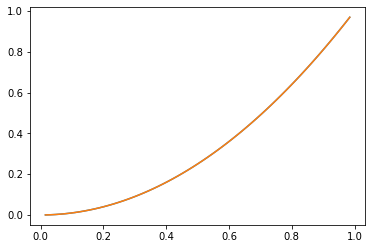

In [159]:
plt.plot(x,U_num[0])
plt.plot(x,exact_sol1(grid_points)[:n-1])

In [160]:
np.linalg.norm(exact_sol1(grid_points).flatten()-np.stack(U_num).flatten(),np.inf)

6.041833700010102e-13

In [140]:
#Err8=np.linalg.norm(exact_sol1(grid_points).flatten()-np.stack(U_num).flatten(),np.inf)

In [147]:
#Err16=np.linalg.norm(exact_sol1(grid_points).flatten()-np.stack(U_num).flatten(),np.inf)

In [154]:
#Err32=np.linalg.norm(exact_sol1(grid_points).flatten()-np.stack(U_num).flatten(),np.inf)

In [162]:
#Err64=np.linalg.norm(exact_sol1(grid_points).flatten()-np.stack(U_num).flatten(),np.inf)

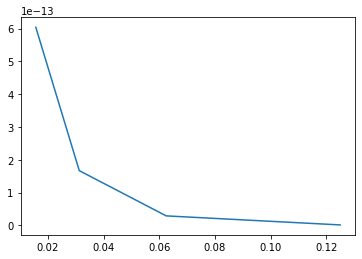

In [169]:
Err=[Err8,Err16,Err32,Err64]
t=np.arange(3,7)
plt.plot(1/2**t,Err)


In [170]:
Err

[1.3322676295501878e-15,
 2.886579864025407e-14,
 1.6686652060116103e-13,
 6.041833700010102e-13]

In [175]:
i=2
np.log2(Err[i]/Err[i+1])

-1.8562919473333142